# ***ENVIDR***: Neural Renderer for Spheres

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/nexuslrf/ENVIDR/blob/main/demo.ipynb)

A minimal example to run our neural renderer in a Jupyter notebook.

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# cpu is completely fine for this notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preparation functions

### IDE Encoder:

In [2]:
def generalized_binomial_coeff(a, k):
    """Compute generalized binomial coefficients."""
    return np.prod(a - np.arange(k)) / np.math.factorial(k)

def assoc_legendre_coeff(l, m, k):
    """Compute associated Legendre polynomial coefficients.
    Returns the coefficient of the cos^k(theta)*sin^m(theta) term in the
    (l, m)th associated Legendre polynomial, P_l^m(cos(theta)).
    """
    return ((-1) ** m * 2**l * np.math.factorial(l)
        / np.math.factorial(k) / np.math.factorial(l - k - m)
        * generalized_binomial_coeff(0.5 * (l + k + m - 1.0), l))

def sph_harm_coeff(l, m, k):
    """Compute spherical harmonic coefficients."""
    return np.sqrt((2.0 * l + 1.0) * np.math.factorial(l - m)
        / (4.0 * np.pi * np.math.factorial(l + m))) * assoc_legendre_coeff(l, m, k)

def get_ml_array(deg_view):
    """Create a list with all pairs of (l, m) values to use in the encoding."""
    ml_list = [(m, 2**i) for i in range(deg_view) for m in range(2**i + 1)]
    ml_array = np.array(ml_list).T
    return ml_array

class IntegratedDirEncoder(nn.Module):
    """Module for integrated directional encoding (IDE).
        from Equations 6-8 of arxiv.org/abs/2112.03907.
    """

    def __init__(self, input_dim=3, deg_view=4):
        """Initialize integrated directional encoding (IDE) module.
        Args:
            deg_view: number of spherical harmonics degrees to use.
        """
        super().__init__()
        self.deg_view = deg_view

        if deg_view > 5:
            raise ValueError("Only deg_view of at most 5 is numerically stable.")

        ml_array = get_ml_array(deg_view)
        l_max = 2 ** (deg_view - 1)
        
        # Create a matrix corresponding to ml_array holding all coefficients, which,
        # when multiplied (from the right) by the z coordinate Vandermonde matrix,
        # results in the z component of the encoding.
        mat = np.zeros((l_max + 1, ml_array.shape[1]))
        for i, (m, l) in enumerate(ml_array.T):
            for k in range(l - m + 1):
                mat[k, i] = sph_harm_coeff(l, m, k)
                
        sigma = 0.5 * ml_array[1, :] * (ml_array[1, :] + 1)
        self.register_buffer("mat", torch.Tensor(mat), False)
        self.register_buffer("ml_array", torch.Tensor(ml_array), False)
        self.register_buffer("pow_level", torch.arange(l_max + 1), False)
        self.register_buffer("sigma", torch.Tensor(sigma), False)
        self.output_dim = (2**deg_view - 1 + deg_view) * 2

    def forward(self, xyz, roughness=0, **kwargs):
        """Compute integrated directional encoding (IDE).
        Args:
            xyz: [..., 3] array of Cartesian coordinates of directions to evaluate at.
            kappa_inv: [..., 1] reciprocal of the concentration parameter of the von
                Mises-Fisher distribution.
        """
        kappa_inv = roughness
        x = xyz[..., 0:1]
        y = xyz[..., 1:2]
        z = xyz[..., 2:3]
        # avoid 0 + 0j exponentiation
        zero_xy = torch.logical_and(x == 0, y == 0)
        y = y + zero_xy
        
        vmz = z ** self.pow_level
        vmxy = (x + 1j * y) ** self.ml_array[0, :]
        sph_harms = vmxy * torch.matmul(vmz, self.mat)
        ide = sph_harms * torch.exp(-self.sigma * kappa_inv)
        
        return torch.cat([torch.real(ide), torch.imag(ide)], dim=-1)       

### Camera Related

In [3]:
trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]])

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]])

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]])

def pose_spherical(theta, phi, radius=4.0):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array(
                [[-1,0,0,0],
                [ 0,0,1,0],
                [ 0,1,0,0],
                [ 0,0,0,1]]) @ c2w
    c2w = c2w 
    return c2w

def nerf_matrix_to_ngp(pose, scale=1, offset=[0, 0, 0]):
    # for the fox dataset, 0.33 scales camera radius to ~ 2
    new_pose = np.array([
        [pose[1, 0], -pose[1, 1], -pose[1, 2], pose[1, 3] * scale + offset[0]],
        [pose[2, 0], -pose[2, 1], -pose[2, 2], pose[2, 3] * scale + offset[1]],
        [pose[0, 0], -pose[0, 1], -pose[0, 2], pose[0, 3] * scale + offset[2]],
        [0, 0, 0, 1],
    ], dtype=np.float32)
    return new_pose

def get_transform_matrix_extrinsics(theta, phi, radius=4.0):
    transform_matrix = pose_spherical(theta, phi, radius)
    return nerf_matrix_to_ngp(transform_matrix)

W, H = 800, 800
camera_angle_x = 0.6194058656692505
focal = W / (2 * np.tan(camera_angle_x / 2))
fl_x, fl_y = focal, focal
cx, cy = W/2, H/2
intrinsics = np.array([fl_x, fl_y, cx, cy])

### Ray Related

In [4]:
def get_rays(poses, intrinsics, H, W):
    ''' get rays
    Args:
        poses: [B, 4, 4], cam2world
        intrinsics: [4]
        H, W, N: int
    Returns:
        rays_o, rays_d: [B, N, 3]
    '''
    device = poses.device
    B = poses.shape[0]
    fx, fy, cx, cy = intrinsics
    
    i, j = torch.meshgrid(torch.linspace(0, W-1, W, device=device), torch.linspace(0, H-1, H, device=device), indexing='ij') # float
    i = i.t().reshape([1, H*W]).expand([B, H*W]) + 0.5
    j = j.t().reshape([1, H*W]).expand([B, H*W]) + 0.5

    zs = torch.ones_like(i)
    xs = (i - cx) / fx * zs
    ys = (j - cy) / fy * zs
    directions = torch.stack((xs, ys, zs), dim=-1)
    directions = directions / torch.norm(directions, dim=-1, keepdim=True)
    rays_d = directions @ poses[:, :3, :3].transpose(-1, -2) # (B, N, 3)

    rays_o = poses[..., :3, 3] # [B, 3]
    rays_o = rays_o[..., None, :].expand_as(rays_d) # [B, N, 3]

    return rays_o, rays_d

def get_sphere_intersections(rays_o, rays_d, r=1.0):
    '''
    Ray-sphere Intersection: https://en.wikipedia.org/wiki/Line-sphere_intersection
    Input: n_rays x 3 ; n_rays x 3
    Output: n_rays x 1, n_rays x 1 (near and far)
    '''
    ray_cam_dot = torch.bmm(rays_d.view(-1, 1, 3),
                            rays_o.view(-1, 3, 1)).squeeze(-1)
    nabla = ray_cam_dot ** 2 - (rays_o.norm(2, 1, keepdim=True) ** 2 - r ** 2)
    nabla_sqrt = torch.sqrt(nabla.clamp_min(0.0))
    near = -ray_cam_dot - nabla_sqrt
    far = -ray_cam_dot + nabla_sqrt
    mask = (nabla >= -1e-4)[..., 0]
    return near, far, mask

## Define Neural Networks

In [5]:
def get_net(in_dim, out_dim, hidden_dim, num_layers, device=device):
    net = []
    for l in range(num_layers-1):
        net.append(nn.Linear(in_dim, hidden_dim, bias=True))
        net.append(nn.ReLU(inplace=True))
        in_dim = hidden_dim
    net.append(nn.Linear(in_dim, out_dim, bias=True))
    net = nn.Sequential(*net)
    return net.to(device)

In [7]:
# sdf network
encoding_dim = 32
feat_dim = 12
sdf_in_dim = encoding_dim + 1 + 1 + 3 # roughness + metallic + base color
sdf_out_dim = feat_dim + 1 + 1 # sdf + roughness(kappa_inv)
sdf_hidden_dim = 64
sdf_net = get_net(sdf_in_dim, sdf_out_dim, sdf_hidden_dim, 3)
roughness_act = nn.Softplus()
roughness_act_scale = 1.0
roughness_bias = -1

# env network
encoder_dir = IntegratedDirEncoder(deg_view=4).to(device)
dir_encoding_dim = encoder_dir.output_dim
env_hidden_dim = 160
env_net = get_net(dir_encoding_dim, feat_dim, env_hidden_dim, 4)

# color networks
diffuse_kappa_inv = 0.64
diffuse_net = get_net(feat_dim+feat_dim, 3, 32, 2)
specular_net = get_net(feat_dim+feat_dim+3+1, 3, 64, 3) # + normal + ndotv

linear2srgb = lambda x: torch.where(x <= 0.0031308, x * 12.92, torch.pow(x, 1/2.4) * 1.055 - 0.055)

### Get pretrained features & weights

In [ ]:
if not os.path.exists('demo'):
    !gdown --fuzzy https://drive.google.com/file/d/1ewz9QuwaMA_rtUd_ZfJdkUiaBHIaOwyu/view?usp=sharing
    !unzip demo.zip

In [16]:
# extract from hash encoding, for a point on the sphere. 
# since this unit sphere has uniform material, 
# we can use any point on the sphere as th proxy.
xyz_encoding = np.loadtxt('demo/xyz_encoding.txt') 
xyz_encoding = torch.from_numpy(xyz_encoding).float().to(device)

# mlp ckpts
sdf_net.load_state_dict(torch.load('demo/sdf_net.pth', map_location=device))
diffuse_net.load_state_dict(torch.load('demo/diffuse_net.pth', map_location=device))
specular_net.load_state_dict(torch.load('demo/specular_net.pth', map_location=device))

<All keys matched successfully>

In [17]:
# HDRIs are from https://github.com/google/filament/tree/main/third_party/environments
env2idx = {   
    "flower_road_2k": 0,
    "flower_road_no_sun_2k": 1,
    "graffiti_shelter_2k": 2,
    "lightroom_14b": 3,
    "noon_grass_2k": 4,
    "parking_garage_2k": 5,
    "pillars_2k": 6,
    "studio_small_02_2k": 7,
    "syferfontein_18d_clear_2k": 8,
    "the_sky_is_on_fire_2k": 9,
    "venetian_crossroads_2k": 10
 }

## Start Rendering

### Parameters to set:

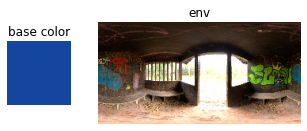

In [18]:
#@title Rendering Parameters { run: "auto" }
# camera_pose
theta = 123 #@param {type:"slider", min:0, max:360, step:1}
phi = 0 #@param {type:"slider", min:-90, max:90, step:1}
radius = 4.0 #@param
# materials
roughness = 0.0 #@param {type:"slider", min:0, max:1, step:0.05}
metallic = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}

R = 20 #@param {type:"slider", min:0, max:255, step:1}
G = 70 #@param {type:"slider", min:0, max:255, step:1}
B = 160 #@param {type:"slider", min:0, max:255, step:1}

base_color = [R/255., G/255., B/255.]

plt.figure(figsize=(8, 4))
pat = np.ones((5, 5, 3)) * np.array(base_color)
plt.subplot(1, 6, 3)
plt.imshow(pat); plt.axis('off'); plt.title('base color')

# environment light [0-10]
env = "graffiti_shelter_2k" #@param ["flower_road_2k", "flower_road_no_sun_2k", "graffiti_shelter_2k", "lightroom_14b", "noon_grass_2k", "parking_garage_2k", "pillars_2k", "studio_small_02_2k", "syferfontein_18d_clear_2k", "the_sky_is_on_fire_2k", "venetian_crossroads_2k"]
env_idx = env2idx[env]

plt.subplot(1, 2, 2)
probe = plt.imread(f'demo/envs/thumbnails/{env}_srgb.jpg')
plt.imshow(probe); plt.axis('off'); plt.title('env')
plt.show()

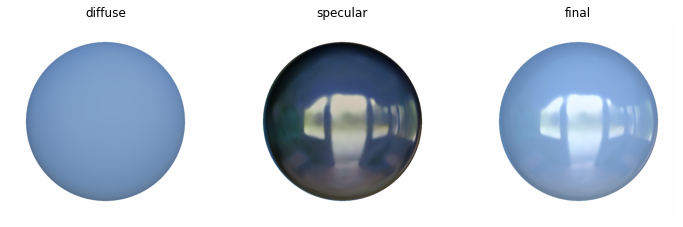

In [19]:
#@title Rendering Steps { vertical-output: true, display-mode: "form" }
####################
# Setup Env. Light #
####################
env_net.load_state_dict(torch.load(f'demo/envs/env_net_{env_idx}.pth', map_location=device))

####################
# Run Ray Marching #
####################
pose = torch.from_numpy(get_transform_matrix_extrinsics(theta, -phi)).float()[None, ...].to(device)
rays_o, rays_d = get_rays(pose, intrinsics, H, W)
rays_o, rays_d = rays_o.view(-1, 3), rays_d.view(-1, 3) # (N, 3)

nears, fars, mask = get_sphere_intersections(rays_o, rays_d)
nears_valid = nears[mask] # [M, 1]
z_vals = nears_valid # only run a surface rendering

dirs = rays_d[mask, None, :] # [M, 1, 3]
xyzs = rays_o[mask, None, :] + dirs * z_vals[:, :, None] # [M, S, 3]

dirs = dirs.view(-1, 3) # [M*S, 3]
xyzs = xyzs.view(-1, 3) # [M*S, 3]
normals = xyzs # since this is a unit sphere

############
# Run MLPs #
############
with torch.no_grad():
    # concate material properties
    material_vec = torch.tensor([roughness, metallic, *base_color], device=device)
    h = torch.cat([xyz_encoding, material_vec], dim=0)[None, ...] # [1, 37]
    # sdf network
    h = sdf_net(h) # [1, 17]
    sdf = h[..., 0] # [1, 1]
    geo_feat = h[..., 1:1+feat_dim] # [1, 12]
    geo_feat = F.normalize(geo_feat, dim=-1) # l2 normalize
    geo_feat = geo_feat.repeat(xyzs.shape[0], 1) # [M*S, 12]
    kappa_inv = roughness_act_scale * roughness_act(h[..., -1] + roughness_bias)[0] # [1]
    
    # encoding directions
    n_enc = encoder_dir(normals, diffuse_kappa_inv) # [M*S, 16]
    w_o = -dirs
    w_r = 2 * torch.sum(w_o * normals, dim=-1, keepdim=True) * normals - w_o
    w_r_enc = encoder_dir(w_r, kappa_inv) # [M*S, 16]
    n_dot_v = torch.sum(normals * w_o, dim=-1, keepdim=True) # [M*S, 1]
    
    # diffuse color
    diffuse_env_feat = env_net(n_enc) # [M*S, 12]
    diffuse_env_feat = F.normalize(diffuse_env_feat, dim=-1) # l2 normalize
    diffuse_h = torch.cat([geo_feat, diffuse_env_feat], dim=-1) # [M*S, 24]
    diffuse_color = diffuse_net(diffuse_h).sigmoid() # [M*S, 3]
    
    # specular color
    specular_env_feat = env_net(w_r_enc) # [M*S, 12]
    specular_env_feat = F.normalize(specular_env_feat, dim=-1) # l2 normalize
    specular_h = torch.cat([geo_feat, normals, specular_env_feat, n_dot_v], dim=-1) # [M*S, 28]
    specular_color = specular_net(specular_h).sigmoid() # [M*S, 3]
    
bg_color = torch.ones(mask.shape[0], 3, device=device)
diffuse = bg_color.masked_scatter(mask[:, None], diffuse_color)
specular = bg_color.masked_scatter(mask[:, None], specular_color)
image = bg_color.masked_scatter(mask[:, None], diffuse_color + specular_color)

out_img = {}
out_img["diffuse"] = linear2srgb(diffuse).view(H, W, 3).cpu().numpy().clip(0, 1)
out_img["specular"] = linear2srgb(specular).view(H, W, 3).cpu().numpy().clip(0, 1)
out_img["final"] = linear2srgb(image).view(H, W, 3).cpu().numpy().clip(0, 1)

# plot results
plt.figure(figsize=(12, 4))
for i, (k, v) in enumerate(out_img.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow(v); plt.title(k); plt.axis('off')